## Import Data and Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.regularizers import L2
from keras.metrics import Precision, Recall, AUC
from keras.utils import to_categorical
from keras.optimizers import Adam
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

# ADC data
data_path = '/content/drive/MyDrive/Computer Vision Project/Data/20230508'
file_names = os.listdir(data_path)
pkl_files = [file for file in file_names if file.endswith('.pkl')]
pkl_files = [pkl_files[0], pkl_files[2], pkl_files[4]]

file_path_y = data_path + '/' + pkl_files[0]
file_path_x = data_path + '/' + pkl_files[1]
file_path_idx = data_path + '/' + pkl_files[2]

with open(file_path_x, 'rb') as file:
  x = pickle.load(file)

with open(file_path_y, 'rb') as file:
  y = pickle.load(file)

with open(file_path_idx, 'rb') as file:
  idx = pickle.load(file)

Mounted at /content/drive


## Split Train / Validation / Test

In [ ]:
# Get a list of the keys
keys = list(idx.keys())

# Get the keys at the desired index
train_key = keys[np.int(0.7*len(keys))] # outputs a list [start_idx, end_idx]
val_key = keys[np.int(0.85*len(keys))]

# Split into training and validation and test
x_train = x[0:idx[train_key][1]]
y_train = y[0:idx[train_key][1]]

x_val = x[idx[train_key][1]:idx[val_key][1]]
y_val = y[idx[train_key][1]:idx[val_key][1]]

x_test = x[idx[val_key][1]:]
y_test = y[idx[val_key][1]:]

# Print shapes
print('x_train shape = ', x_train.shape)
print('y_train shape = ', y_train.shape)

print('x_val shape = ', x_val.shape)
print('y_val shape = ', y_val.shape)

print('x_test shape = ', x_test.shape)
print('y_test shape = ', y_test.shape)

x_train shape =  (19160, 128, 128, 3)
y_train shape =  (19160,)
x_val shape =  (4074, 128, 128, 3)
y_val shape =  (4074,)
x_test shape =  (4108, 128, 128, 3)
y_test shape =  (4108,)


## Redefine Class Weights

In [ ]:
import numpy as np
from sklearn.utils import class_weight
from collections import Counter

# Assuming you have your labels as a NumPy array or list
labels = y_train

# Find the sample sizes of each class
total_samples = x_train.shape[0]

def sample_per_class_counter(data):
  samples_per_class = []
  total_samples = data.shape[0]

  for class_label in np.unique(data):
    counter = 0
    for i in data:
      if i == class_label:
        counter += 1
    
    samples_per_class.append(counter)
  
  return samples_per_class

# Calculate class weights
sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=labels)
class_weights = np.unique(sample_weights)

# Create a dictionary mapping class index to class weight
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(class_weights_dict)

samples_per_class = sample_per_class_counter(y_train)
weights_per_class = torch.tensor([total_samples / class_sample_size for class_sample_size in samples_per_class], dtype=torch.float32)
weights_per_class

rescaling_factor = total_samples / torch.sum(weights_per_class)
weights_per_class *= rescaling_factor
weights_per_class_dict = {0: weights_per_class[0].item(), 1: weights_per_class[1].item()}
weights_per_class_dict

{0: 0.5177258971033291, 1: 14.603658536585366}


{0: 655.9999389648438, 1: 18504.0}

### Check Data Distributions

In [ ]:
# Find the sample sizes of each class (test)
samples_per_class_test = sample_per_class_counter(y_test)

samples_per_class_test = [100*x/y_test.shape[0] for x in samples_per_class_test]
samples_per_class_test

# Find the sample sizes of each class (train)
samples_per_class_train = sample_per_class_counter(y_train)

samples_per_class_train = [100*x/y_train.shape[0] for x in samples_per_class_train]

# Find the sample sizes of each class (validation)
samples_per_class_val = sample_per_class_counter(y_val)

samples_per_class_val = [100*x/y_val.shape[0] for x in samples_per_class_val]

print('Train distribution = ', samples_per_class_train)
print('Validation distribution = ', samples_per_class_val)
print('Test distribution = ', samples_per_class_test)

Train distribution =  [96.57620041753654, 3.4237995824634657]
Validation distribution =  [94.96809032891507, 5.031909671084929]
Test distribution =  [96.22687439143135, 3.7731256085686464]


## ResNet50

In [ ]:
# We will define a function that will build a model per the approach above

def construct_model(input_shape, metrics=['AUC']):

  base_model = keras.applications.ResNet50(
      include_top=False,   # this makes ResNet50 headless
      weights="imagenet",
      input_tensor=None,
      input_shape=input_shape,
      pooling=None,
      classes=1000
  )

  # Freeze all layers in the base_model
  for layer in base_model.layers:
    layer.trainable = False

  # Unfreeze only the layers in the last block (i.e., conv5) of the ResNet50 base model
  for layer in base_model.layers:
    if 'conv5' in layer.name:
      layer.trainable = True

  inputs = keras.Input(shape=input_shape)

  x = keras.layers.Normalization()(inputs) #normalizing

  # The base model contains batchnorm layers. We want to keep them in inference mode
  # when we unfreeze the base model for fine-tuning, so we make sure that the
  # base_model is running in inference mode here. We didn't cover batchnorm 
  # layers in class so just take our word for it :-)
  x = base_model(x, training=False)
  
  # Next we connect the output from our headless model to our little NN
  # we will flatten the output of the headless
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(512, activation='relu')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(256, activation='relu')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(1, activation='sigmoid', name='output')(x)
  
  model = keras.Model(inputs, outputs)
  model.summary()

  model.compile(loss='binary_crossentropy', 
                optimizer=keras.optimizers.Adam(0.2*1e-4), #here we choose a different rate for Adam than default for better convergence
                metrics=metrics) 
  
  return model

In [ ]:
model = construct_model((128,128,3))
early_stopping = tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss',                 # Metric to monitor
                          patience=5,                        # Number of epochs with no improvement after which training will be stopped
                          restore_best_weights=True
                          )                                   # Restore the weights of the best epoch

history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=100,  # Increase the number of epochs to allow for early stopping
                    validation_split=0.2,
                    callbacks=early_stopping,
                    class_weight=class_weights_dict) 

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 normalization (Normalizatio  (None, 128, 128, 3)      7         
 n)                                                              
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                              

## Evaluation
### Raw | Train

In [ ]:
def evaluate_thresholds(y_true, y_pred_probs, thresholds):
  results = []
  for threshold in thresholds:

      # Convert probabilities to binary predictions based on threshold
      y_pred = np.where(y_pred_probs >= threshold, 1, 0)
      
      # Calculate evaluation metrics
      positive_count = sum(y_pred)
      accuracy = accuracy_score(y_true, y_pred)
      precision = precision_score(y_true, y_pred)
      recall = recall_score(y_true, y_pred)
      f1 = f1_score(y_true, y_pred)
      auc = roc_auc_score(y_true, y_pred)
      
      results.append((threshold, positive_count, f1, precision, recall, auc, accuracy))
  
  results_df = pd.DataFrame(results, columns=["Threshold","positive_count" ,"F1", "Precision", "Recall", "AUC", "Accuracy"])
  return results_df

In [ ]:
y_pred_probs = model.predict(x_train)
results_df = evaluate_thresholds(y_train, y_pred_probs, np.arange(0, 1, 0.05))
results_df

599/599 [==============================] - 5s 7ms/step


,Threshold,positive_count,F1,Precision,Recall,AUC,Accuracy
0,0.00,[19160],0.066209,0.034238,1.000000,0.500000,0.034238
1,0.05,[10804],0.107853,0.057201,0.942073,0.695799,0.466388
2,0.10,[8812],0.126954,0.068202,0.916159,0.736208,0.568580
3,0.15,[7637],0.140842,0.076470,0.890244,0.754542,0.628132
4,0.20,[6750],0.152309,0.083556,0.859756,0.762725,0.672338
5,0.25,[6005],0.163339,0.090591,0.829268,0.767071,0.709134
6,0.30,[5402],0.169693,0.095150,0.783537,0.759689,0.737474
7,0.35,[4815],0.178395,0.101350,0.743902,0.755031,0.765397
8,0.40,[4272],0.189935,0.109551,0.713415,0.753919,0.791649
9,0.45,[3704],0.202294,0.119060,0.672256,0.747958,0.818476


In [ ]:
y_pred_probs = model.predict(x_val)
results_df = evaluate_thresholds(y_val, y_pred_probs, np.arange(0, 1, 0.05))
results_df

128/128 [==============================] - 1s 8ms/step


,Threshold,positive_count,F1,Precision,Recall,AUC,Accuracy
0,0.00,[4074],0.095817,0.050319,1.000000,0.500000,0.050319
1,0.05,[2350],0.133855,0.072766,0.834146,0.635476,0.456799
2,0.10,[1879],0.154511,0.085684,0.785366,0.670662,0.567501
3,0.15,[1602],0.168235,0.094881,0.741463,0.683345,0.631075
4,0.20,[1376],0.172043,0.098837,0.663415,0.671459,0.678694
5,0.25,[1219],0.182584,0.106645,0.634146,0.676339,0.714286
6,0.30,[1062],0.192581,0.114878,0.595122,0.676083,0.748895
7,0.35,[937],0.206655,0.125934,0.575610,0.681964,0.777614
8,0.40,[802],0.210526,0.132170,0.517073,0.668591,0.804860
9,0.45,[699],0.223451,0.144492,0.492683,0.669061,0.827688


In [ ]:
y_pred_probs = model.predict(x_test)
results_df = evaluate_thresholds(y_test, y_pred_probs, np.arange(0, 1, 0.05))
results_df

129/129 [==============================] - 1s 8ms/step


,Threshold,positive_count,F1,Precision,Recall,AUC,Accuracy
0,0.00,[4108],0.072719,0.037731,1.000000,0.500000,0.037731
1,0.05,[1944],0.123869,0.066872,0.838710,0.689909,0.552337
2,0.10,[1469],0.146552,0.081007,0.767742,0.713115,0.662610
3,0.15,[1204],0.160412,0.090532,0.703226,0.713110,0.722249
4,0.20,[1029],0.168919,0.097182,0.645161,0.705075,0.760467
5,0.25,[903],0.179584,0.105205,0.612903,0.704251,0.788705
6,0.30,[804],0.173097,0.103234,0.535484,0.676545,0.806962
7,0.35,[699],0.173302,0.105866,0.477419,0.659656,0.828140
8,0.40,[596],0.175766,0.110738,0.425806,0.645866,0.849318
9,0.45,[514],0.197309,0.128405,0.425806,0.656237,0.869279


## Map Raw to Patient

In [ ]:
def output_mapper(model, dataset, idx, x, chosen_threshold, y_true):
  
  keys = list(idx.keys())

  # Indexing referenced relative to the FULL dataset (i.e., index 0 to 27k)
  if dataset == 'train':
    start_key_pos = 0
    end_key_pos = np.int(0.7*len(keys))
    sliced_keys = keys[start_key_pos : end_key_pos+1]
    
  elif dataset == 'val':
    start_key_pos = np.int(0.7*len(keys))+1
    end_key_pos = np.int(0.85*len(keys))
    sliced_keys = keys[start_key_pos : end_key_pos+1]
    # print(sliced_keys)

  elif dataset == 'test':
    start_key_pos = np.int(0.85*len(keys))+1
    sliced_keys = keys[start_key_pos : len(keys)]

  y_pred_probs = model.predict(x)
  y_pred = np.where(y_pred_probs >= chosen_threshold, 1, 0)
  true_y_mapped = []
  pred_y_mapped = []

  for i in range(0, len(sliced_keys)):

    # Extract indexing for start and end image per patient
    start_img_idx = idx[sliced_keys[i]][0]    # 0
    end_img_idx = idx[sliced_keys[i]][1]      # 31
    # print(start_img_idx, end_img_idx)

    # Slice y true and predicted
    sliced_y = y_true[start_img_idx : end_img_idx]

    if dataset == 'val' or dataset == 'test':
      start_img_idx = start_img_idx - idx[sliced_keys[0]][0]
      end_img_idx = end_img_idx - idx[sliced_keys[0]][0]
      # print(start_img_idx, end_img_idx)
    
    sliced_y_pred = y_pred[start_img_idx : end_img_idx]

    # Store in lists
    if 1 in sliced_y:
      true_y_mapped.append(1)
    else:
      true_y_mapped.append(0)
    
    if 1 in sliced_y_pred:
      pred_y_mapped.append(1)
    else:
      pred_y_mapped.append(0)  

  return true_y_mapped, pred_y_mapped  

In [ ]:
true_y_train_mapped, pred_y_train_mapped = output_mapper(model, 'train', idx, x_train, 0.05, y)
print(len(true_y_train_mapped), len(pred_y_train_mapped))
true_y_val_mapped, pred_y_val_mapped = output_mapper(model, 'val', idx, x_val, 0.05, y)
print(len(true_y_val_mapped), len(pred_y_val_mapped))
true_y_test_mapped, pred_y_test_mapped = output_mapper(model, 'test', idx, x_test, 0.05, y)
print(len(true_y_test_mapped), len(pred_y_test_mapped))

599/599 [==============================] - 4s 7ms/step
864 864
128/128 [==============================] - 1s 7ms/step
185 185
129/129 [==============================] - 1s 7ms/step
184 184


In [ ]:
accuracy_train = accuracy_score(true_y_train_mapped, pred_y_train_mapped)
precision_train = precision_score(true_y_train_mapped, pred_y_train_mapped)
recall_train = recall_score(true_y_train_mapped, pred_y_train_mapped)
f1_train = f1_score(true_y_train_mapped, pred_y_train_mapped)
auc_train = roc_auc_score(true_y_train_mapped, pred_y_train_mapped)

print("----- TRAIN -----")
print(f"F1 Score: {f1_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"AUC: {auc_train:.4f}")
print(f"Accuracy: {accuracy_train:.4f}")
print("\n")

accuracy_val = accuracy_score(true_y_val_mapped, pred_y_val_mapped)
precision_val = precision_score(true_y_val_mapped, pred_y_val_mapped)
recall_val = recall_score(true_y_val_mapped, pred_y_val_mapped)
f1_val = f1_score(true_y_val_mapped, pred_y_val_mapped)
auc_val = roc_auc_score(true_y_val_mapped, pred_y_val_mapped)

print("----- VALIDATION -----")
print(f"F1 Score: {f1_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"AUC: {auc_val:.4f}")
print(f"Accuracy: {accuracy_val:.4f}")
print("\n")

accuracy_test = accuracy_score(true_y_test_mapped, pred_y_test_mapped)
precision_test = precision_score(true_y_test_mapped, pred_y_test_mapped)
recall_test = recall_score(true_y_test_mapped, pred_y_test_mapped)
f1_test = f1_score(true_y_test_mapped, pred_y_test_mapped)
auc_test = roc_auc_score(true_y_test_mapped, pred_y_test_mapped)

print("----- TEST -----")
print(f"F1 Score: {f1_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"AUC: {auc_test:.4f}")
print(f"Accuracy: {accuracy_test:.4f}")
print("\n")

# Define the metrics and corresponding values
metrics = ["F1 Score", "Precision", "Recall", "AUC", "Accuracy"]
train_scores = [f1_train, precision_train, recall_train, auc_train, accuracy_train]
val_scores = [f1_val, precision_val, recall_val, auc_val, accuracy_val]
test_scores = [f1_test, precision_test, recall_test, auc_test, accuracy_test]

# Create the dataframe
data = {"Train": train_scores, "Validation": val_scores, "Test": test_scores}
df = pd.DataFrame(data, index=metrics)

# Print the dataframe
df.transpose()

----- TRAIN -----
F1 Score: 0.2462
Precision: 0.1404
Recall: 1.0000
AUC: 0.5439
Accuracy: 0.2060


----- VALIDATION -----
F1 Score: 0.3158
Precision: 0.1886
Recall: 0.9706
AUC: 0.5151
Accuracy: 0.2270


----- TEST -----
F1 Score: 0.3077
Precision: 0.1818
Recall: 1.0000
AUC: 0.5617
Accuracy: 0.2663




,F1 Score,Precision,Recall,AUC,Accuracy
Train,0.246154,0.140351,1.000000,0.543883,0.206019
Validation,0.315789,0.188571,0.970588,0.515095,0.227027
Test,0.307692,0.181818,1.000000,0.561688,0.266304


## Feature Activation Map (CAM)

In [ ]:
base_model_layer = model.get_layer('resnet50')
last_conv_layer = base_model_layer.get_layer('conv5_block3_out')

In [ ]:
def make_cam(input_image, model, last_conv_layer_name):
    # First, we create a model that maps the input tensor of the base model to the last convolutional layer
    resnet_model = model.get_layer('resnet50')
    last_conv_layer = resnet_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(resnet_model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the output of the last convolutional layer to the final predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in ['global_average_pooling2d', 'dense', 'dropout', 'dense_1', 'dropout_1', 'output']:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute the activations of the last conv layer by running the image through the first model
        # Outputs a 1x4x4x2048 tensor
        last_conv_layer_output = last_conv_layer_model(input_image)
        # print(last_conv_layer_output)

        # Run this output through the second model
        # We're watching the tensor that holds the activations of the last conv layer
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        # print(preds)

        # Get the index of the highest predicted class
        top_pred_index = tf.argmax(preds[0])
        # print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]
        # print(top_class_channel)

    # This is the gradient of the output neuron (top predicted or chosen class)
    # with regard to the output feature map of the last conv layer
    # Outputs a 1x4x4x2048 tensor of gradients of the output prediction wrt the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    # print(grads)

    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    # For each of the 2048 channels, we average the gradients over the width and height dimensions, resulting in a vector pooled_grads
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # print(pooled_grads)

    # We multiply each channel in the feature map array by "how important this channel is" (i.e., the pooled_grads) with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]          # 4x4x2048
    pooled_grads = pooled_grads.numpy()                                 # 2048 vector
    for i in range(pooled_grads.shape[-1]):                             # For each of the 2048 channels...
        last_conv_layer_output[:, :, i] *= pooled_grads[i]              # Multiply each channel by the pooled_grads

    # The channel-wise mean of the resulting feature map is our heatmap of class activation
    # Each of the 2048 channels learns a different feature from the image due to the different filters
    # The `grads` variable determines the change in the output prediction per unit change in each pixel of the 1x4x4x2048 tensor `last_conv_layer_output`
    # We take the pooled_grads (i.e., mean along the height and width dimension per channel) to get a "weight" of each channel - if one channel has many pixels causing significant changes in output prediction, it will be "weighted" heavily
    # Multiply the "weights" with each channel from `last_conv_layer_output` and then now we take the mean along the channel dimension
    # Returns a 4x4 tensor. Channels that were weighted more heavily should have their "activations" reflected in the resulting 4x4 tensor
    heatmap = np.mean(last_conv_layer_output, axis=-1)                  

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    return heatmap


Training set, Index = 1241


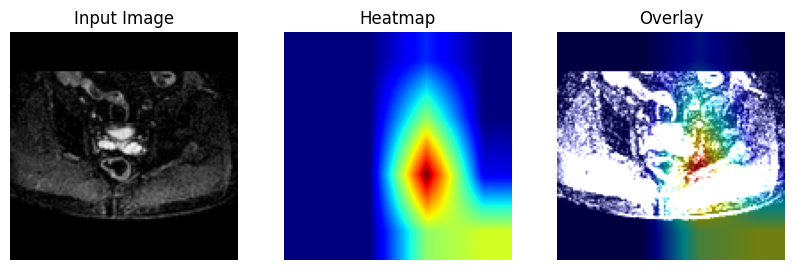

Training set, Index = 1991


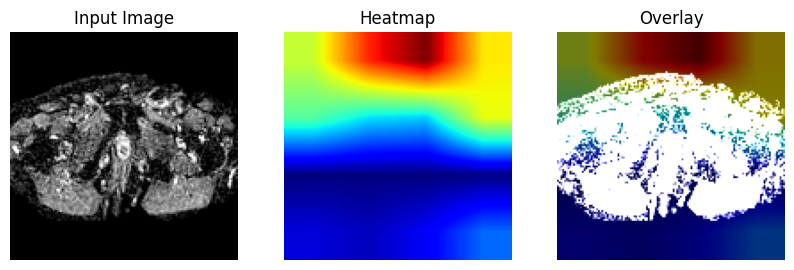

Training set, Index = 5890


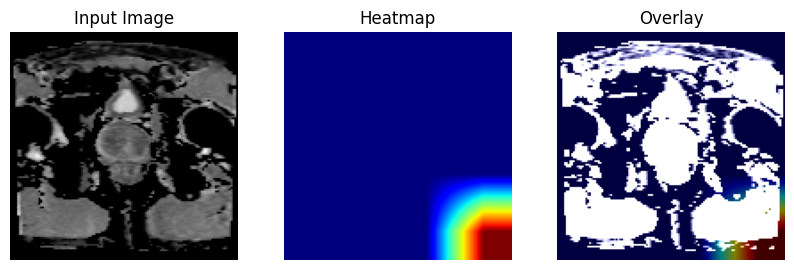

Training set, Index = 8583


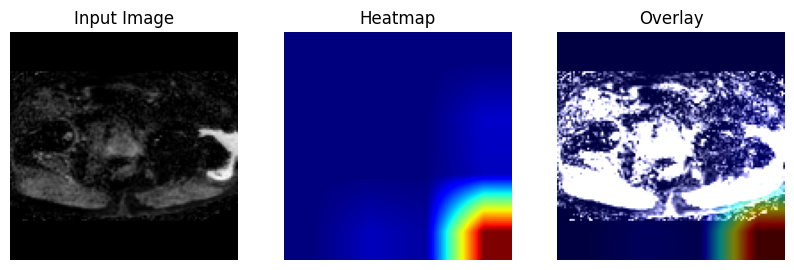

Training set, Index = 9538


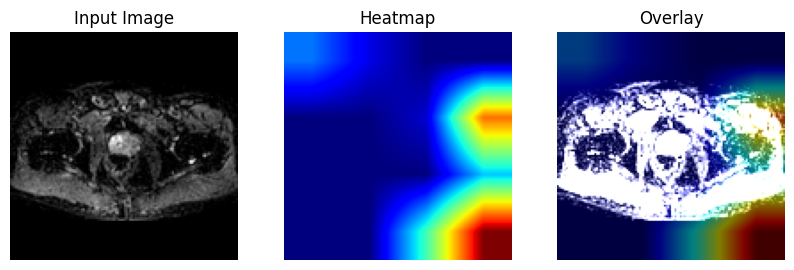

Training set, Index = 13084


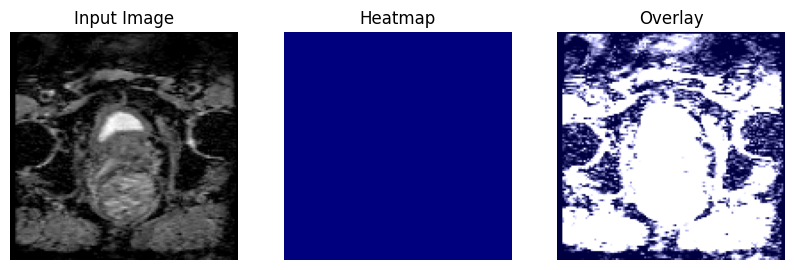

Training set, Index = 13296


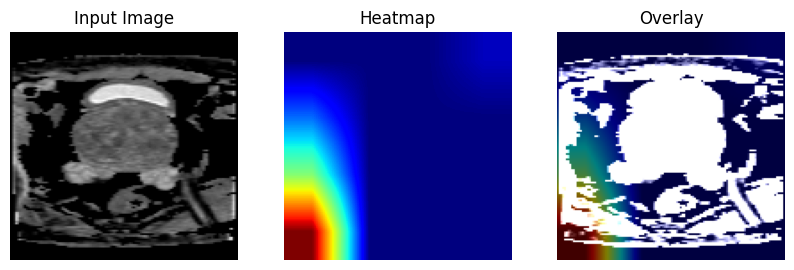

Training set, Index = 16673


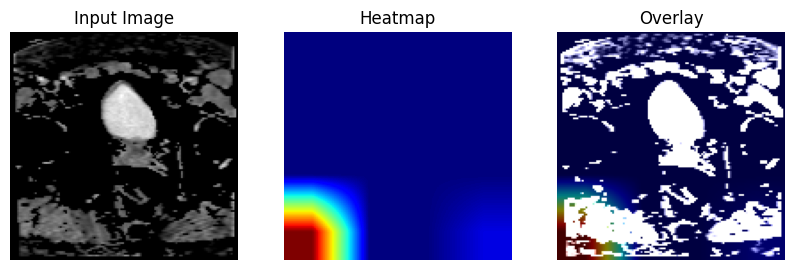

Training set, Index = 16899


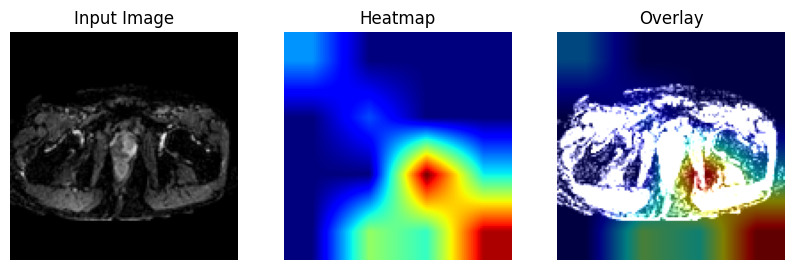

Training set, Index = 18880


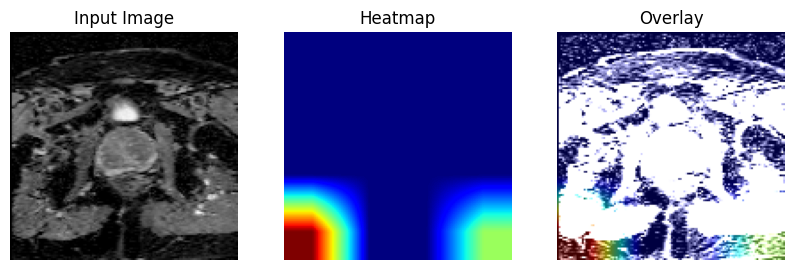

In [ ]:
def display_cam(image_partial, image_full, cam):
    plt.figure(figsize=(10, 10))

    plt.subplot(131)
    plt.title('Input Image')
    plt.imshow(image_partial, cmap='gray')  # Use grayscale color map
    plt.axis('off')

    plt.subplot(132)
    plt.title('Heatmap')
    plt.imshow(cam, cmap='jet')
    plt.axis('off')

    plt.subplot(133)
    cam_resized = cv2.resize(cam, (image_full.shape[1], image_full.shape[0]))
    cam_resized = np.uint8(255 * cam_resized)
    cam_jet = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
    cam_jet = cv2.cvtColor(cam_jet, cv2.COLOR_BGR2RGB)

    # Convert image and heatmap to float in the range [0, 1]
    image_normalized = image_full  # Convert grayscale image to 3-channel
    image_normalized = image_normalized.astype(float) / 255
    cam_normalized = cam_jet.astype(float) / 255

    # Adjust the weight of the heatmap overlay
    alpha = 0.5
    superimposed_img = cv2.addWeighted(image_normalized, 1-alpha, cam_normalized, alpha, 0)

    plt.title('Overlay')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()


# Randomly sample 10 indices:
import random

rand_train_idx = random.sample(range(x_train.shape[0]), 10)
rand_train_idx = np.sort(rand_train_idx)

for i in rand_train_idx:
  print(f"Training set, Index = {i}")
  img = x_train[i]
  cam_image = make_cam(np.expand_dims(img, axis=0), model, 'conv5_block3_out')

  # Resize the heatmap to be the same size as the original image
  cam_image_resized = cv2.resize(cam_image, (128, 128))

  # Display heatmap
  display_cam(img[:,:,0], img, cam_image_resized)

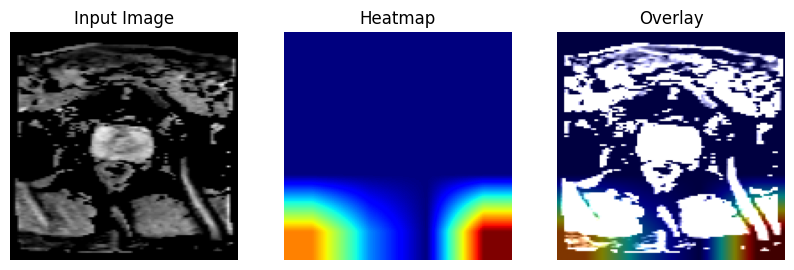

In [ ]:
img = x_train[125]
cam_image = make_cam(np.expand_dims(img, axis=0), model, 'conv5_block3_out')

# Resize the heatmap to be the same size as the original image
cam_image_resized = cv2.resize(cam_image, (128, 128))

# Display heatmap
display_cam(img[:,:,0], img, cam_image_resized)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(19160, 128, 128, 3)
(4074, 128, 128, 3)
(4108, 128, 128, 3)


In [ ]:
y[125]

1

In [ ]:
data_path = '/content/drive/MyDrive/We Like Balls/Data/20230508'
file_path = data_path + '/' + '20230508_adc_annotated_label.pkl'
with open(file_path, 'rb') as file:
  annotated_img = pickle.load(file)

annotated_img.shape

(27342,)

In [ ]:
def generate_featuremap_unit(model_cut, unit_id, img):
    # Extract activation from model
    # Mark the model as being used for inference
    model_cut.eval()
    # # Crop the image
    # im = center_crop(im_input)
    # Place the image into a batch of size 1, and use the model to get an intermediate representation
    activations = model_cut(img.unsqueeze(0))
    # Print the shape of our representation
    print(activations.size())
    # Extract the only result from this batch, and take just the `unit_id`th channel
    # Return this channel
    return activations.squeeze()[unit_id]

def visualize_featuremap(im_input, feature_map, alpha=0.3):
    # Normalize to [0..1], with a little leeway (0.9999) in case feature_map has 0 range
    feature_map = feature_map / (feature_map.max() + 1e-10)
    # Convert to numpy (detach() just seperates a tensor from the gradient)
    feat_numpy = feature_map.detach().numpy()
    # Resize the feature map to our original image size (our strided conv layers reduce the size of the image)
    feat_numpy = cv2.resize(feat_numpy, (im_input.shape[1], im_input.shape[0]))
    # Invert to make the heatmap look more natural
    map_t = 1 - feat_numpy
    # Add an extra dimension to make this a [H,W,C=1] image
    feat_numpy = np.expand_dims(feat_numpy, axis=2)

    # Convert to image (UINT8 from 0-255)
    map_t = 255 * map_t
    map_t = map_t.astype(np.uint8)
    # Use a color map to change this from BW to a nice color
    map_t = cv2.applyColorMap(map_t, cv2.COLORMAP_JET)
    # Combine the heatmap with the original image so you can see which section of the image is activated
    im_final = np.multiply((alpha * im_input + (1 - alpha) * map_t), feat_numpy) + np.multiply(
        im_input, 1 - feat_numpy
    )
    # Return final visualization
    return im_final


def remove_last_layers(model, num_layers=2):
    # TODO (2a): remove the last 2 layers of resnet
    # Note: the .children() function of nn.Module
    # (which resnet50 inherits from) and nn.Sequential() will be useful
    children = list(model.children())
    
    # Remove the last `num_layers` modules
    model = nn.Sequential(*children[:-num_layers])

    return model


model_cut = remove_last_layers(model, num_layers=2)

AttributeError: ignored